# Kaggle Competition Final Project

# *1C Company* - Predict Future Sales

**Motivation**

*This challenge serves as final project for the "How to win a data science competition" Coursera course. In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. We are asking you to **predict total sales for every product and store in the next month**. By solving this competition you will be able to apply and enhance your data science skills.*

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Submissions are evaluated by **root mean squared error** (RMSE). True target values are clipped into [0,20] range. For each id in the test set, you must predict a total number of sales.

Source: https://www.kaggle.com/c/competitive-data-science-final-project

**Summary**

    1. Getting a look at the data
    2. Preprocessing raw data into features
        2.1. Making sense of the test set ID values
        2.2. Extracting categorical features from Russian item names
        2.3. Remove duplicates
        2.4. Text processed features with TF-IDF
        2.5. Starting point for data engineering
        2.6. Lagged based features
        2.7. Trend based features
        2.8. Feature matrix
    3. Exploratory data analysis
        3.1. Target variable
        3.2. Multivariate heatmaps (numerical/categorical pairings)
    4. Advanced feature engineering
        4.1. Mean encoding on categorical features
        4.2. Matrix factorization on text processed features   
    5. Model training
        5.1. Validation scheme
        5.2. LightGBM Regressor
        5.3. XGBoost Regressor
        5.4. Linear Regression
    6. Ensembling and test predictions
        6.1. Ensembling: XGBoost + Linear Regression
        6.2. Leaderboard test prediction

**Guidelines**

1. *Clarity*: The clear step-by-step instruction on how to produce the final submit file is provided. Code has comments where it is needed and meaningful function names
2. *Feature preprocessing and generation with respect to models*: Several simple features are generated. For non-tree-based models preprocessing is used or the absence of it is explained
3. *Feature extraction from text and images*: Features from text are extracted. Special preprocessings for text are utilized (TF-IDF, stemming, levenshtening...)
4. *EDA*: Several interesting observations about data are discovered and explained. Target distribution is visualized, time trend is assessed
5. *Validation*: Type of train/test split is identified and used for validation. Type of public/private split is identified
6. *Data leakages*: Data is investigated for data leakages and investigation process is described. Found data leakages are utilized
7. *Metrics optimization*: Correct metric is optimized
8. *Advanced Features I (mean encodings)*: Mean-encoding is applied. Mean-encoding is set up correctly, i.e. KFold or expanding scheme are utilized correctly
9. *Advanced Features II*: At least one feature from this topic is introduced
10. *Hyperparameter tuning*: Parameters of models are roughly optimal
11. *Ensembles*: Ensembling is utilized (linear combination counts). Validation with ensembling scheme is set up correctly, i.e. KFold or Holdout is utilized. Models from different classes are utilized (at least two from the following: KNN, linear models, RF, GBDT, NN)

**Packages (notice: not all of them are used)**

In [20]:
# Basic packages
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

# Utilities
import gc
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from math import ceil
import copy
import os
from IPython.display import clear_output

# Machine learning packages
import nltk
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
#from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE (not used)
import lightgbm as lgb
import xgboost as xgb
#import catboost as cat
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars, ElasticNet
#from bayes_opt import BayesianOptimization (not used)
#import shap (not used)
from sklearn.externals import joblib
#import tensorflow as tf (not used)
#os.environ['KERAS_BACKEND'] = 'tensorflow' (not used)
#import keras (not used)

# Part 1/6: Getting a look at the data

Let's take a quick look at what type of data we are dealing with, by using pandas' functions `shape`, `unique()` and `head()`.

In [3]:
path = 'data/'

# Training set. Daily historical data from January 2013 to October 2015.
train = pd.read_csv(path+'sales_train.csv.gz')

# Testing set. You need to forecast the sales for these shops and products for November 2015.
test = pd.read_csv(path+'test.csv.gz').set_index('ID')

# Additional information
items = pd.read_csv(path+'items.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
shops = pd.read_csv(path+'shops.csv')

In [4]:
train['sales'] = train['item_cnt_day']*train['item_price']
print(train.shape)
print(train.nunique())
train.head()

(2935849, 7)
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
sales             24775
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
0,02.01.2013,0,59,22154,999.00,1.00,999.00
1,03.01.2013,0,25,2552,899.00,1.00,899.00
2,05.01.2013,0,25,2552,899.00,-1.00,-899.00
3,06.01.2013,0,25,2554,"1,709.05",1.00,"1,709.05"
4,15.01.2013,0,25,2555,"1,099.00",1.00,"1,099.00"


In [5]:
print(test.shape)
print(test.nunique())
test.head()

(214200, 2)
shop_id      42
item_id    5100
dtype: int64


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [6]:
print(items.shape)
print(items.nunique())
items.head()

(22170, 3)
item_name           22170
item_id             22170
item_category_id       84
dtype: int64


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
print(item_categories.shape)
print(item_categories.nunique())
item_categories.head()

(84, 2)
item_category_name    84
item_category_id      84
dtype: int64


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Part 2/6: Preprocessing raw data into features

## 2.1. Making sense of the testing ID values

As the data is raw, we need to preprocess it in order to extract features for monthly sales prediction. We notice in the testing set that each ID represents an item sold (`item_id`) at a particular shop (`shop_id`). Let's check if each ID represents a unique **item_id - shop_id** pair.

In [8]:
test1 = copy.copy(test)
test1['shop_id'] = test1['shop_id'].map(str)
test1['item_id'] = test1['item_id'].map(str)
test1['key'] = test1[['shop_id', 'item_id']].apply(lambda x: '-'.join(x), axis=1)
print(test1['key'].nunique() == len(test1))
del test1; gc.collect();

True


This is indeed the case.

## 2.2. Extracting categorical features from Russian item names

We add more categorical features for items in order to enrich our training data:

In [9]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [10]:
item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [11]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [12]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


## 2.3. Creating text processed features with TF-IDF

In [13]:
items1 = pd.read_csv(path+'items.csv')
item_categories1 = pd.read_csv(path+'item_categories.csv')
shops1 = pd.read_csv(path+'shops.csv')

In [14]:
# For items
nb_features=25
tfidf = text.TfidfVectorizer(max_features=nb_features)
items1['item_name_len'] = items1['item_name'].map(len)  # Name lenth
items1['item_name_wc'] = items1['item_name'].map(lambda x: len(str(x).split(' ')))  # Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items1['item_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    items1['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
items1.head()

,item_name,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,...,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,41,14,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,68,9,0.00,0.00,0.00,0.00,0.00,...,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.48
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,45,26,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,47,26,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,***КОРОБКА (СТЕКЛО) D,4,40,43,25,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [15]:
# For shop names
tfidf = text.TfidfVectorizer(max_features = nb_features)
shops1['shop_name_len'] = shops1['shop_name'].map(len)  # Name lenth
shops1['shop_name_wc'] = shops1['shop_name'].map(lambda x: len(str(x).split(' ')))  # Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops1['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    shops1['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
shops1.head()

,shop_name,shop_id,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,"!Якутск Орджоникидзе, 56 фран",0,29,4,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,"!Якутск ТЦ ""Центральный"" фран",1,29,4,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.69,0.65
2,"Адыгея ТЦ ""Мега""",2,16,3,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
3,"Балашиха ТРК ""Октябрь-Киномир""",3,30,3,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
4,"Волжский ТЦ ""Волга Молл""",4,24,4,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.00,0.00,0.00


## 2.4. Check for duplicates

There are 24 duplicate rows in our data:

In [16]:
cols = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=cols).value_counts())
train.drop_duplicates(subset=cols, inplace=True)

False    2935825
True          24
dtype: int64


## 2.5. Creating a starting point for data engineering (with test set)

In [17]:
train1 = []
cols = ['date_block_num','shop_id','item_id']
for block_num in range(34):
    temp = train[train.date_block_num==block_num]
    train1.append(np.array(list(product([block_num], temp['shop_id'].unique(), temp['item_id'].unique()))))
    
train1 = pd.DataFrame(np.vstack(train1), columns=cols)
train1['date_block_num'] = train1['date_block_num'].astype(np.int8)
train1['shop_id'] = train1['shop_id'].astype(np.int8)
train1['item_id'] = train1['item_id'].astype(np.int16)
train1.sort_values(cols,inplace=True);
train1.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [18]:
temp = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
temp.columns = ['item_cnt_month']
temp.reset_index(inplace=True)

train1 = pd.merge(train1, temp, on=cols, how='left')
train1['item_cnt_month'] = (train1['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))
print(train1.shape)
train1.head()

(10913850, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.00
1,0,0,27,0.00
2,0,0,28,0.00
3,0,0,29,0.00
4,0,0,32,6.00


One of the most challenging aspects of this competition is that the testing set to be submitted on Kaggle is devoid of features. The test set represents pairs of `(item ID, shop ID)` for the month of November 2015. It is thus a time series problem where we are using sales' results from January 2013 to October 2015 to predict future sales (November 2015). We add the test set to the training set by adding a 34th `date_block_num` key.

In [19]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

train2 = pd.concat([train1, test], ignore_index=True, sort=False, keys=cols)
train2.fillna(0, inplace=True)
print(train2.shape)
train2.tail()

(11128050, 4)


,date_block_num,shop_id,item_id,item_cnt_month
11128045,34,45,18454,0.00
11128046,34,45,16188,0.00
11128047,34,45,15757,0.00
11128048,34,45,19648,0.00
11128049,34,45,969,0.00


In [20]:
train2.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month'],
      dtype=object)

## 2.6. Create lagged features

We want to capture past behavior of several item-shop, item category-shop or item-city pairings (among others):

- *date_avg_item_cnt*
- *date_item_avg_item_cnt*
- *date_shop_avg_item_cnt*
- *date_cat_avg_item_cnt*
- *date_shop_cat_avg_item_cnt*
- *date_shop_subtype_avg_item_cnt*
- *date_city_avg_item_cnt*
- *date_shop_type_avg_item_cnt*
- *date_shop_subtype_avg_item_cnt*
- *date_item_city_avg_item_cnt*
- *date_type_avg_item_cnt*
- *date_subtype_avg_item_cnt*

In [21]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [22]:
train3 = pd.merge(train2, shops, on=['shop_id'], how='left')
train3 = pd.merge(train3, items, on=['item_id'], how='left')
train3 = pd.merge(train3, item_categories, on=['item_category_id'], how='left')

In [23]:
train3.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'city_code', 'item_category_id', 'type_code', 'subtype_code'],
      dtype=object)

In [24]:
########## 1. Create 'date_avg_item_cnt'
temp = train3.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_avg_item_cnt']          ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num'], how='left')
train3 = lag_feature(train3, [1], 'date_avg_item_cnt')
train3.drop(['date_avg_item_cnt'], axis=1, inplace=True)

########## 2. Create 'date_item_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')
train3.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

########## 3. Create 'date_shop_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','shop_id'], how='left')
train3 = lag_feature(train3, [1, 2, 3, 6, 12], 'date_shop_avg_item_cnt')
train3.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

########## 4. Create 'date_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_cat_avg_item_cnt']      ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_cat_avg_item_cnt')
train3.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

########## 5. Create 'date_shop_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_cat_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_cat_avg_item_cnt')
train3.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

########## 6. Create 'date_shop_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_type_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_type_avg_item_cnt')
train3.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

########## 7. Create 'date_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_type_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_type_avg_item_cnt')
train3.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

########## 8. Create 'date_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_city_avg_item_cnt')
train3.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

########## 9. Create 'date_shop_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_subtype_avg_item_cnt']   ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_subtype_avg_item_cnt')
train3.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

########## 10. Create 'date_item_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'item_id', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_item_city_avg_item_cnt')
train3.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

########## 11. Create 'date_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_subtype_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_subtype_avg_item_cnt')
train3.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
train3.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,0,19,0.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,0,27,0.00,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,0,28,0.00,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,0,29,0.00,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,0,32,6.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## 2.7. Create time series trend features

We also want to capture past trends that might give us a hint of the future sales evolution (and thus information on the testing set):

In [25]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [26]:
# Trend features for prices
temp = train.groupby(['item_id']).agg({'item_price': ['mean']})
temp.columns = ['item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train3, temp, on=['item_id'], how='left')

temp = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
temp.columns = ['date_item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','item_id'], how='left')

lags = [1,2,3,4,5,6]
train4 = lag_feature(train4, lags, 'date_item_avg_item_price')

for i in lags:
    train4['delta_price_lag_'+str(i)] = \
    (train4['date_item_avg_item_price_lag_'+str(i)] - train4['item_avg_item_price']) / train4['item_avg_item_price']
    
train4['delta_price_lag'] = train4.apply(select_trend, axis=1)
train4['delta_price_lag'].fillna(0, inplace=True)

dropped_cols = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    dropped_cols += ['date_item_avg_item_price_lag_'+str(i)]
    dropped_cols += ['delta_price_lag_'+str(i)]

train4.drop(dropped_cols, axis=1, inplace=True)

In [27]:
# Trend features for revenue
temp = train.groupby(['date_block_num','shop_id']).agg({'sales': ['sum']})
temp.columns = ['date_shop_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','shop_id'], how='left')

temp = train4.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
temp.columns = ['shop_avg_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['shop_id'], how='left')

train4['delta_revenue'] = (train4['date_shop_revenue'] - train4['shop_avg_revenue']) / train4['shop_avg_revenue']
train4 = lag_feature(train4, [1], 'delta_revenue')
train4.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [28]:
train4['delta_revenue_lag_1'] = train4['delta_revenue_lag_1'].fillna(0.0)

In [29]:
print(train4.shape)
train4.head()

(11128050, 29)


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,0,19,0.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
1,0,0,27,0.00,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
2,0,0,28,0.00,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
3,0,0,29,0.00,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
4,0,0,32,6.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00


## 2.8. Feature matrix

We finally have our feature matrix $X$:

In [30]:
df = train4[train4['date_block_num'] > 11]
print(df.shape)

for col in df.columns:
    if ('_lag_' in col) & (df[col].isnull().any()):
        if ('item_cnt' in col):
            df[col].fillna(0, inplace=True)   

(6639294, 29)


Finally, we add the text processed features (with TF-IDF) from section 2.3:

In [31]:
df = pd.merge(df, items1, how='left', on='item_id')
df = pd.merge(df, shops1, how='left', on='shop_id')
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,12,2,27,0.00,0,19,5,10,0.41,0.09,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
1,12,2,30,0.00,0,40,11,4,0.41,1.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
2,12,2,31,0.00,0,37,11,1,0.41,0.54,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
3,12,2,32,1.00,0,40,11,4,0.41,1.93,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00
4,12,2,33,1.00,0,37,11,1,0.41,0.91,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00


In [32]:
df.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'city_code', 'item_category_id_x', 'type_code', 'subtype_code',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'item_name', 'item_category_id_y',
       'item_name_len', 'item_name_wc', 'item_name_tfidf_0',
      

In [33]:
df.drop(['item_name', 'item_name_len', 'item_name_wc', 'item_category_id_y',
         'shop_name', 'shop_name_len', 'shop_name_wc'], axis=1, inplace=True)
print(df.shape)

(6639294, 79)


In [34]:
cat_features = ['shop_id', 'item_id', 'city_code', 'item_category_id_x', 'type_code', 'subtype_code']

In [35]:
del train1, train2, train3, train4, temp
gc.collect()

49

# Part 3/6: Exploratory data analysis

## 3.1. Target variable

The **target variable** to be predicted is the `item_cnt_month` (number of products sold). Let's check its time series evolution and KDE distribution:

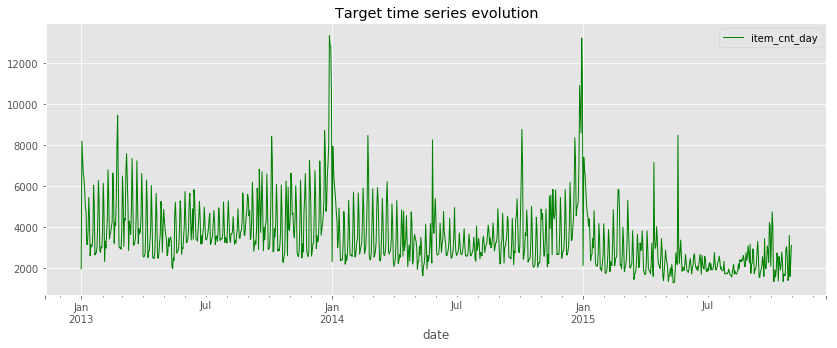

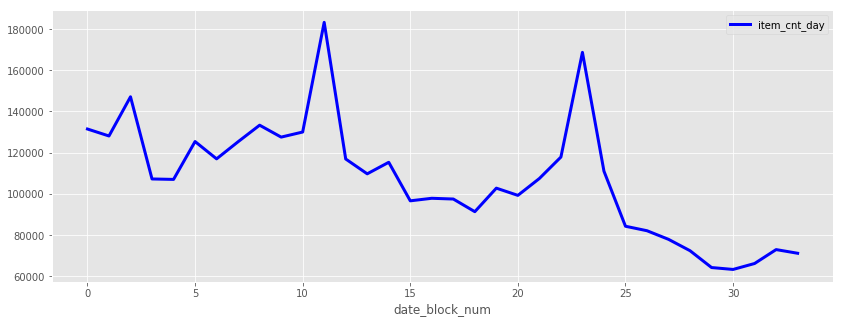

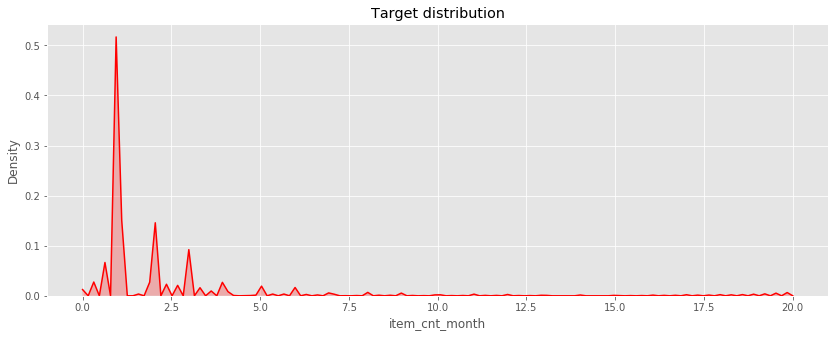

In [36]:
train['date'] = pd.to_datetime(train['date'], format="%d.%m.%Y")
train.groupby('date').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), title='Target time series evolution', lw=1.0, color='green')
train.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).plot(figsize=(14,5), lw=3.0, color='blue')
plt.show()

fig, ax = plt.subplots(figsize=(14,5))
ax = sns.kdeplot(df['item_cnt_month'].values, shade=True, color="red", ax=ax)
ax.set_xlabel('item_cnt_month')
ax.set_ylabel('Density')
ax.set_title('Target distribution')
plt.show()

Next we look at the daily performance of each shop:

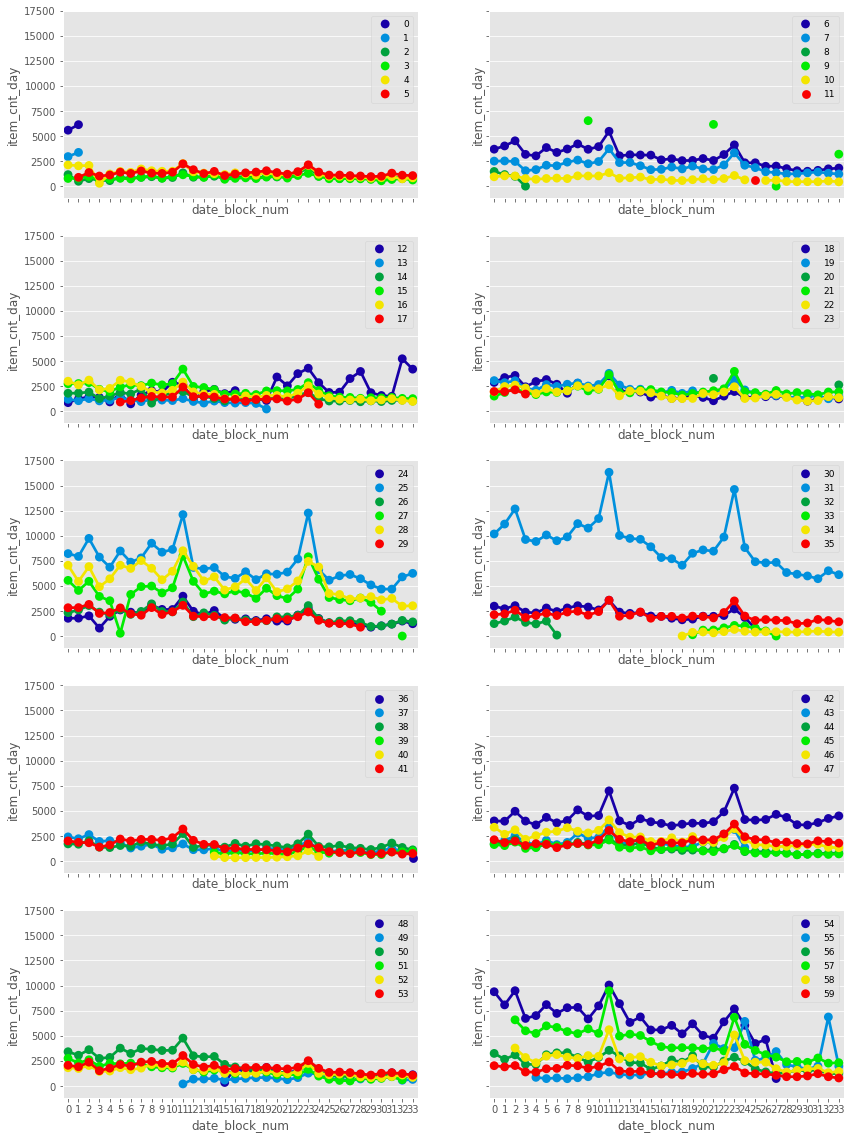

In [37]:
temp = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(14,20))
num_graph = 10
id_per_graph = ceil(temp.shop_id.max() / num_graph)
#fig.suptitle('Time series evolution of sales (per shop)')
x = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', palette='nipy_spectral',
                      data=temp[np.logical_and(x*id_per_graph <= temp['shop_id'],
                                               temp['shop_id'] < (x+1)*id_per_graph)],
                      ax=axes[i][j], grid=True, lw=1.0)
        axes[i,j].legend(loc='upper right')
        plt.setp(axes[i,j].get_legend().get_texts(), fontsize='9')
        plt.setp(axes[i,j].get_legend().get_title(), fontsize='10')
        x += 1

sns.reset_orig()

## 3.2. Multivariate heatmaps (numerical/categorical pairings)

An interesting visualization approach would be to pair different categorical variables (ex. `item_category_id`, `shop_id`, `city_code`) together and check the *performance* of different pairs (total sales' performance with `item_cnt_month`).

Several item categories are barely (or not even) sold in a number of shops.

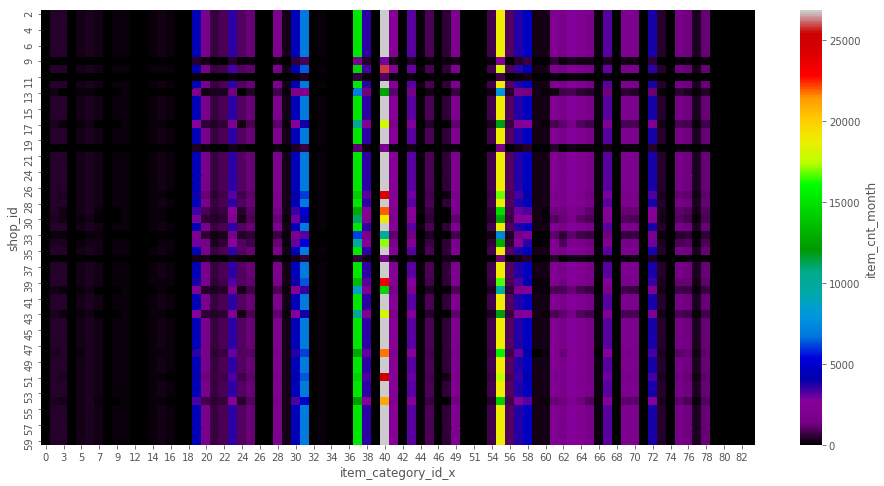

In [38]:
stores_hm = df.pivot_table(index='shop_id', columns='item_category_id_x', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

The same goes for cities:

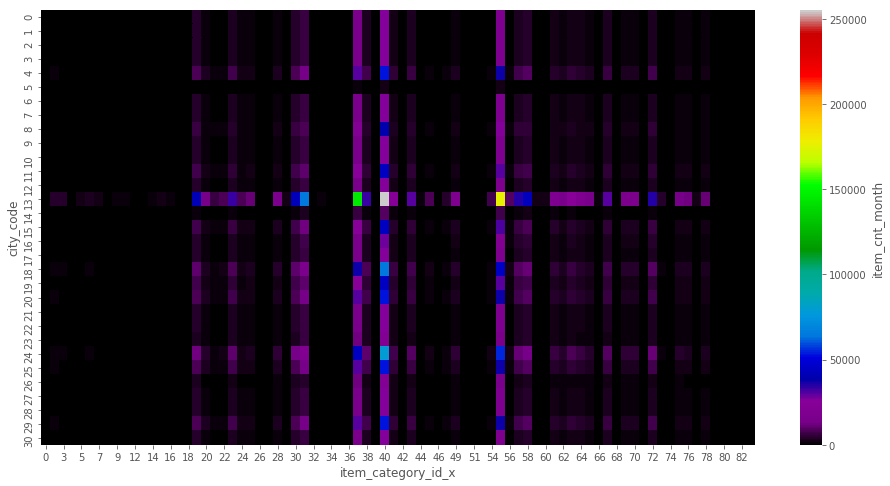

In [39]:
stores_hm = df.pivot_table(index='city_code', columns='item_category_id_x', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

This additional plot reveals the number of shops per cities and their sales' performance.

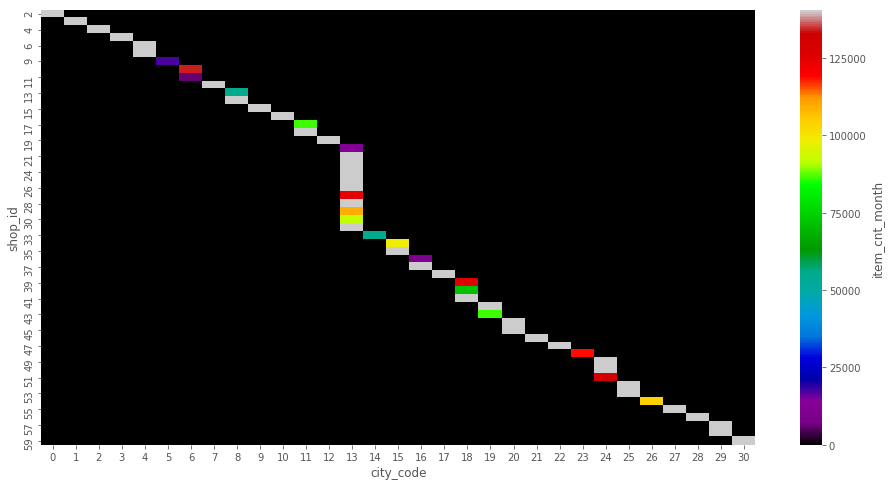

In [40]:
stores_hm = df.pivot_table(index='shop_id', columns='city_code', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

Categorical variables are clearly important as several pairs of shop - items perform better than others. Let's exploit this by using target/mean encodings.

# Part 4/6: Advanced Feature Engineering

## 4.1. Mean encodings on categorical features

Mean encodings look to map a high cardinality categorical feature into a 1D array (instead of high numbers of them had we used one-hot encoding) based on how often the target variable appears on average in the categorical feature. It is a convenient approach since it also has a clever way of imputing missing values among categorical variables.

In [41]:
df1 = copy.copy(df)
df1.reset_index(inplace=True)

cv = KFold(n_splits=5, shuffle=False)
new_features = []

check = False
for train_idx, valid_idx in cv.split(df1):
    
    # Train/validation split
    X_train, X_valid = df1.iloc[train_idx,:], df1.iloc[valid_idx,:]
    
    # Mean encoding
    for col in cat_features:
        means = X_valid[col].map(X_train.groupby(col).item_cnt_month.mean())
        col_new = col+'_target_enc'
        X_valid[col_new] = means
        
        # Results
        df1.loc[valid_idx, col_new] = X_valid
        
        # Store new columns
        if check==False:
            new_features.append(col_new)
    
    check = True

print(new_features)

['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc', 'item_category_id_x_target_enc', 'type_code_target_enc', 'subtype_code_target_enc']


In [42]:
# Dealing with missing values
new_features = ['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc',
                'item_category_id_x_target_enc', 'type_code_target_enc', 'subtype_code_target_enc']
prior = np.mean(df1['item_cnt_month'].values)
df1[new_features] = df1[new_features].fillna(prior)
df1.head()

,index,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id_x,type_code,subtype_code,date_avg_item_cnt_lag_1,...,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_x_target_enc,type_code_target_enc,subtype_code_target_enc
0,0,12,2,27,0.00,0,19,5,10,0.41,...,0.50,0.00,0.00,0.00,0.14,0.04,0.14,0.55,0.57,0.51
1,1,12,2,30,0.00,0,40,11,4,0.41,...,0.50,0.00,0.00,0.00,0.14,0.19,0.14,0.23,0.20,0.23
2,2,12,2,31,0.00,0,37,11,1,0.41,...,0.50,0.00,0.00,0.00,0.14,0.32,0.14,0.16,0.20,0.16
3,3,12,2,32,1.00,0,40,11,4,0.41,...,0.50,0.00,0.00,0.00,0.14,0.58,0.14,0.23,0.20,0.23
4,4,12,2,33,1.00,0,37,11,1,0.41,...,0.50,0.00,0.00,0.00,0.14,0.34,0.14,0.16,0.20,0.16


In [43]:
df1.drop(cat_features, axis=1, inplace=True)
df1.drop('index', axis=1, inplace=True)
cat_features = new_features

In [44]:
df1.columns.values

array(['date_block_num', 'item_cnt_month', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'item_name_tfidf_0', 'item_name_tfidf_1',
       'item_name_tfidf_2', 'item_name_tfidf_3', 'item_name_tfidf_4',
       'item_name_tfidf_5', 'item_name_tfidf_6', 'item_name_tfidf_7',
       'item_name_tf

## 4.2. Matrix factorization of TFIDF processed features

We look to reduce the *dimensionality* of the TFIDF-processed features (from 50 dimensions to 10) and extract nonlinear relationships between the text features with **Non-Negative Matrix Factorization (NMF)**:

In [45]:
tfidf_features = ['item_name_tfidf_0', 'item_name_tfidf_1', 'item_name_tfidf_2',
                  'item_name_tfidf_3', 'item_name_tfidf_4', 'item_name_tfidf_5',
                  'item_name_tfidf_6', 'item_name_tfidf_7', 'item_name_tfidf_8',
                  'item_name_tfidf_9', 'item_name_tfidf_10', 'item_name_tfidf_11',
                  'item_name_tfidf_12', 'item_name_tfidf_13', 'item_name_tfidf_14',
                  'item_name_tfidf_15', 'item_name_tfidf_16', 'item_name_tfidf_17',
                  'item_name_tfidf_18', 'item_name_tfidf_19', 'item_name_tfidf_20',
                  'item_name_tfidf_21', 'item_name_tfidf_22', 'item_name_tfidf_23',
                  'item_name_tfidf_24', 'shop_name_tfidf_0', 'shop_name_tfidf_1',
                  'shop_name_tfidf_2', 'shop_name_tfidf_3', 'shop_name_tfidf_4',
                  'shop_name_tfidf_5', 'shop_name_tfidf_6', 'shop_name_tfidf_7',
                  'shop_name_tfidf_8', 'shop_name_tfidf_9', 'shop_name_tfidf_10',
                  'shop_name_tfidf_11', 'shop_name_tfidf_12', 'shop_name_tfidf_13',
                  'shop_name_tfidf_14', 'shop_name_tfidf_15', 'shop_name_tfidf_16',
                  'shop_name_tfidf_17', 'shop_name_tfidf_18', 'shop_name_tfidf_19',
                  'shop_name_tfidf_20', 'shop_name_tfidf_21', 'shop_name_tfidf_22',
                  'shop_name_tfidf_23', 'shop_name_tfidf_24']

Xtrain = df1[df1['date_block_num']<34][tfidf_features]
Xtest = df1[df1['date_block_num']==34][tfidf_features]
print(Xtrain.shape, Xtest.shape)
#X_all = pd.concat([Xtrain, Xtest], ignore_index=True)
#X_all.shape

(6425094, 50) (214200, 50)


In [46]:
nmf = NMF(n_components=10, init=None, solver='cd', beta_loss='frobenius', tol=0.0001, max_iter=200)
nmf.fit(df1[tfidf_features]);

In [47]:
Xtrain = nmf.transform(Xtrain)
Xtest = nmf.transform(Xtest)

In [48]:
print(Xtrain.shape, Xtest.shape)

(6425094, 10) (214200, 10)


In [49]:
df1.drop(tfidf_features, axis=1, inplace=True)

In [57]:
tfidf_reduced_df = pd.concat([pd.DataFrame(Xtrain), pd.DataFrame(Xtest)], axis=0)
tfidf_reduced_df.columns = ['tfidf_interaction_1', 'tfidf_interaction_2', 'tfidf_interaction_3',
                            'tfidf_interaction_4', 'tfidf_interaction_5', 'tfidf_interaction_6',
                            'tfidf_interaction_7', 'tfidf_interaction_8', 'tfidf_interaction_9',
                            'tfidf_interaction_10']
print(tfidf_reduced_df.shape)
tfidf_reduced_df.head()

(6639294, 10)


,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
0,0.00,0.00,0.00,0.00,0.00,0.03,0.02,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00
2,0.00,0.00,0.04,0.00,0.00,0.03,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00
4,0.00,0.00,0.04,0.00,0.00,0.03,0.00,0.00,0.00,0.00


In [63]:
for col in tfidf_reduced_df.columns:
    print(col)
    test1 = tfidf_reduced_df[col].values
    df1[col] = test1

tfidf_interaction_1
tfidf_interaction_2
tfidf_interaction_3
tfidf_interaction_4
tfidf_interaction_5
tfidf_interaction_6
tfidf_interaction_7
tfidf_interaction_8
tfidf_interaction_9
tfidf_interaction_10


In [64]:
df1.head()

,date_block_num,item_cnt_month,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,...,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
0,12,0.00,0.41,0.09,0.04,0.13,0.07,0.16,0.15,0.10,...,0.00,0.00,0.00,0.00,0.00,0.03,0.02,0.00,0.00,0.00
1,12,0.00,0.41,1.02,1.02,0.52,0.89,0.00,0.15,0.10,...,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00
2,12,0.00,0.41,0.54,0.60,0.54,0.30,0.00,0.15,0.10,...,0.00,0.00,0.04,0.00,0.00,0.03,0.00,0.00,0.00,0.00
3,12,1.00,0.41,1.93,1.80,1.26,1.89,5.38,0.15,0.10,...,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00
4,12,1.00,0.41,0.91,0.33,0.72,1.00,1.36,0.15,0.10,...,0.00,0.00,0.04,0.00,0.00,0.03,0.00,0.00,0.00,0.00


In [65]:
df1.columns.values

array(['date_block_num', 'item_cnt_month', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'shop_id_target_enc', 'item_id_target_enc',
       'city_code_target_enc', 'item_category_id_x_target_enc',
       'type_code_target_enc', 'subtype_code_target_enc',
       'tfidf_interaction_1', 'tfidf

In [66]:
df1.to_csv('data.csv')

In [21]:
df1 = pd.read_csv('data.csv', index_col=0)

# Part 5/6: Model training

We will implement the following models:

- **Linear Regression**: preprocessing is required and we will use `StandardScaler` (mean zero with unit variance);
- **XGBoost / LightGBM**: no preprocessing as decision trees are capable of handling features with different scales.

## 5.1. Validation scheme

We choose **holdout** as our validation scheme: our training set runs from January 2013 to September 2015, while our validation set runs on October 2015. The test set runs on November 2015. This scheme was chosen to mimic the time series nature of our  machine learning problem: predicting for future time periods.

In [24]:
all_data = copy.copy(df1)

X_train = all_data[all_data['date_block_num']<33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<33]['item_cnt_month']

X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

X_test =  all_data[all_data['date_block_num']==34].drop(['item_cnt_month'], axis=1)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(6186922, 38)
(6186922,)
(238172, 38)
(238172,)
(214200, 38)


In [55]:
X_test.head()

,date_block_num,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,...,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
6425094,34,0.26,0.57,2.51,2.83,1.98,1.30,0.19,0.21,0.25,...,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6425095,34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6425096,34,0.26,0.95,1.86,3.57,1.61,0.00,0.19,0.21,0.25,...,0.00,0.03,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00
6425097,34,0.26,0.64,1.12,1.55,0.00,0.00,0.19,0.21,0.25,...,0.00,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
6425098,34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.03,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00


## 5.2. LightGBM Regressor

The correct metric to be used is **root mean squared error**.

Our first model is the regularized gradient boosting library LightGBM:

In [68]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

model_lgbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid,
                       early_stopping_rounds=200, categorical_feature=cat_features,
                       verbose_eval=50)

Training until validation scores don't improve for 200 rounds.
[50]	valid_0's rmse: 0.99583
[100]	valid_0's rmse: 0.973801
[150]	valid_0's rmse: 0.970991
[200]	valid_0's rmse: 0.966659
[250]	valid_0's rmse: 0.963562
[300]	valid_0's rmse: 0.963191
[350]	valid_0's rmse: 0.964798
[400]	valid_0's rmse: 0.962421
[450]	valid_0's rmse: 0.961661
[500]	valid_0's rmse: 0.958449
[550]	valid_0's rmse: 0.963145
[600]	valid_0's rmse: 0.96242
[650]	valid_0's rmse: 0.965405
Early stopping, best iteration is:
[491]	valid_0's rmse: 0.957839


In [69]:
print(np.sqrt(mean_squared_error(Y_valid, model_lgbm.predict(X_valid))))

0.9591511680233902


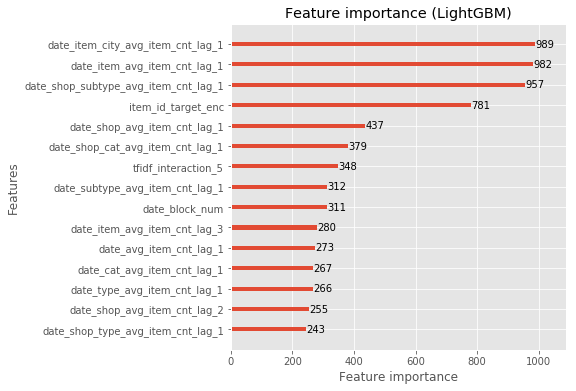

In [70]:
lgb.plot_importance(model_lgbm, max_num_features=15, figsize=(6,6), title='Feature importance (LightGBM)')
plt.show()

In [71]:
joblib.dump(model_lgbm, 'models/model1_lgbm.pkl');

In [25]:
model_lgbm = joblib.load('models/model1_lgbm.pkl')

## 5.3. XGBoost Regressor

Similar to LightGBM, we have the popular XGBoost library:

In [75]:
model_xgb = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,
                             colsample_bytree=0.8, subsample=0.8, eta=0.2, seed=42,
                             reg_alpha=2.0, reg_lambda=2.0)

model_xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_valid, Y_valid)],
              verbose=False, early_stopping_rounds=100)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=2.0, reg_lambda=2.0, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)

In [77]:
print(np.sqrt(mean_squared_error(Y_valid, model_xgb.predict(X_valid))))

0.96524113


In [78]:
joblib.dump(model_xgb, 'models/model2_xgbm.pkl');

In [26]:
model_xgb = joblib.load('models/model2_xgbm.pkl') 

In [81]:
print(model_xgb.best_iteration)

34


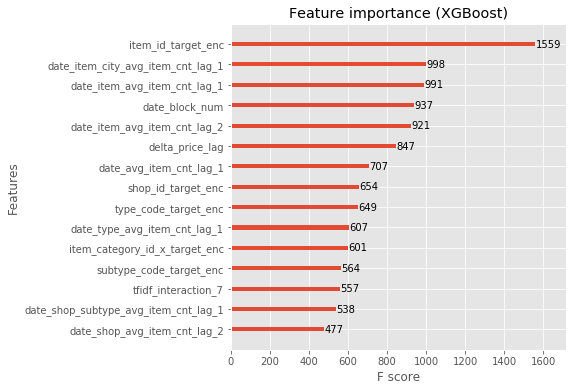

In [82]:
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(model_xgb, max_num_features=15, title='Feature importance (XGBoost)', ax=ax)
plt.show()

## 5.4. Linear regression

Linear models are decent benchmarks which is why we implement a number of them. We implement *feature scaling* for these following models:

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [48]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid_std))))
joblib.dump(model_linreg, 'models/model3_linreg.pkl');

0.9900095967506807


In [49]:
model_ridge = Ridge(alpha=4.0, fit_intercept=True, max_iter=1000, solver='saga')
model_ridge.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid_std))))
joblib.dump(model_ridge, 'models/model4_ridge.pkl');

0.990014154251089


In [50]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train_std, Y_train)
print(np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid_std))))
joblib.dump(model_lasso, 'models/model5_lasso.pkl');

1.1365538511881084


Linear models give decent enough results but there are clearly better models (ex. gradient boosting trees).

# Part 6/6: Ensembling and test predictions

## 6.1. Ensembling: LightGBM + Linear Regression

**Ensembling metafeatures**

We will implement the KFold scheme Time Series implemented in the previous assignment:

*In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.*

1. *Split the train data into chunks of duration T. Select first M chunks.*
2. *Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.*
3. *Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.*

We start with our **1st generation features**:

In [103]:
del Xtrain, Xtest, tfidf_reduced_df
gc.collect()

11465

In [27]:
model_lgbm = joblib.load('models/model1_lgbm.pkl')
model_linreg = joblib.load('models/model3_linreg.pkl')

In [30]:
Y_valid_lgbm = model_lgbm.predict(X_valid)
Y_valid_lreg = model_linreg.predict(X_valid_std)
X_valid_level2 = np.c_[Y_valid_lgbm, Y_valid_lreg]
X_valid_level2[:10,:]

array([[ 0.02400371, -0.06265706],
       [ 0.07732405, -0.04090647],
       [ 0.09288108,  0.11597319],
       [ 0.19394983,  0.4008569 ],
       [ 0.03486246,  0.00994295],
       [ 0.02207116, -0.08366191],
       [ 0.02005064, -0.09086203],
       [ 0.02400371, -0.10312346],
       [ 0.02400371, -0.10568967],
       [ 0.02400371, -0.09369241]])

Then our **2nd generation features**:

In [31]:
X_train = all_data[all_data['date_block_num']<=32].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<=32]['item_cnt_month']
X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

In [32]:
dates = all_data['date_block_num']
last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)
dates_train = dates[dates < last_block]
dates_test  = dates[dates == last_block]

Test `date_block_num` is 34


In [33]:
periods = np.arange(26, 33, 1)
periods

array([26, 27, 28, 29, 30, 31, 32])

In [34]:
dates_train_level2 = dates_train[dates_train.isin(periods)]
Y_train_level2 = Y_train[dates_train.isin(periods)]
X_train_level2 = np.zeros([Y_train_level2.shape[0], 2])

In [35]:
Y_train[dates_train.isin(periods)].shape == dates_train_level2.shape

True

In [38]:
# Now fill `X_train_level2` with metafeatures
params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

for cur_block_num in periods:
    
    print('cur_block_num:', cur_block_num)
    
    # 1. Split `X_train` into parts
    x = all_data[all_data['date_block_num']<cur_block_num].drop(['item_cnt_month'], axis=1)
    y = all_data[all_data['date_block_num']<cur_block_num]['item_cnt_month'].values
    x_test =  all_data[all_data['date_block_num']==cur_block_num].drop(['item_cnt_month'], axis=1)
    y_test =  all_data[all_data['date_block_num']==cur_block_num]['item_cnt_month'].values
    
    # 2. Fit linear regression
    print('Linear regression')
    lr = LinearRegression(fit_intercept=True, normalize=True)
    scaler = StandardScaler().fit(x)
    x_std = scaler.transform(x)
    x_test_std = scaler.transform(x_test)
    lr.fit(x_std, y)
    Y_test_1 = lr.predict(x_test_std)
    
    # 3. Fit LightGBM and put predictions
    print('LightGBM')
    n_trees = 500
    lgb_train = lgb.Dataset(x, y)
    lgb_valid = lgb.Dataset(x_test, y_test)
    model_lgbm = lgb.train(params, lgb_train, num_boost_round=n_trees,
                           valid_sets=lgb_valid, early_stopping_rounds=50,
                           verbose_eval=50)
    Y_test_2 = model_lgbm.predict(x_test)
    
    # 4. Store predictions from 2. and 3. in the right place of `X_train_level2`
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[Y_test_1, Y_test_2]
    clear_output()

print(X_train_level2.mean(axis=0))

[0.31901372 0.25432125]


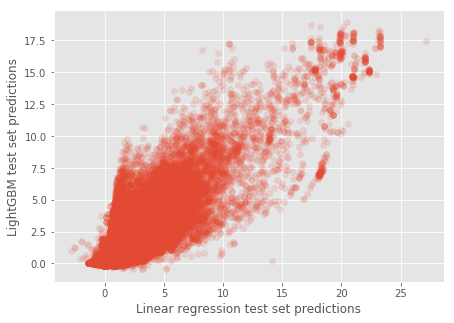

In [42]:
plt.figure(figsize=(7,5))
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], marker='o', alpha=0.15)
plt.xlabel('Linear regression test set predictions')
plt.ylabel('LightGBM test set predictions')
plt.show()

Finally, we have **stacking**:

In [43]:
y_train_level2 = Y_train[dates_train.isin(periods)]
lr_stack = LinearRegression().fit(X_train_level2, y_train_level2)

In [44]:
train_preds = lr_stack.predict(X_train_level2)
rmse_train = np.sqrt(mean_squared_error(y_train_level2, train_preds))

valid_preds = lr_stack.predict(X_valid_level2)
rmse_valid = np.sqrt(mean_squared_error(Y_valid, valid_preds))

print('RMSE Train: %f' % rmse_train)
print('RMSE Test : %f' % rmse_valid)

RMSE Train: 0.808426
RMSE Test : 0.998334


## 6.2. Leaderboard test predictions

We submit all our test predictions to the Kaggle leaderboard (https://www.kaggle.com/c/competitive-data-science-predict-future-sales):

In [51]:
Y_test_lgbm = model_lgbm.predict(X_test).clip(0, 20)
Y_test_xgbm = model_xgb.predict(X_test).clip(0, 20)
Y_test_lreg = model_linreg.predict(X_test).clip(0, 20)
Y_test_ridge = model_ridge.predict(X_test).clip(0, 20)
Y_test_lasso = model_lasso.predict(X_test).clip(0, 20)

In [52]:
models = [Y_test_lgbm, Y_test_xgbm, Y_test_lreg, Y_test_ridge,
          Y_test_lasso]

names = ['LGBM', 'XGBM', 'LINREG', 'RIDGE', 'LASSO']

for model, name in zip(models, names):
    temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': model})
    temp.to_csv('submissions/submission_'+str(name)+'.csv', index=False)

My official submission: **XGBoost** (from section 5.3) on the CSV file `submission1.csv`

In [56]:
temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': Y_test_xgbm})
temp.to_csv('submission1.csv', index=False)

Public leaderboard score (RMSE): **0.96204**